# **NLP GROUP PROJECT - MODELLING**

### **- Wilson Lee**    **- Radhika Patel** **- Arshad Irfan Faisal** **- Felipe Basurto** **- Maurizio Polizzi**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install tabulate nltk retrying transformers lyricsgenius

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00


In [3]:
import json
import random
import re
import string
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import lightgbm as lgb

import torch
from torch.utils.data import DataLoader, TensorDataset

from transformers import AlbertTokenizer, AlbertForSequenceClassification

import lyricsgenius

from IPython.core.display import display, HTML

# Download the stopwords resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

------------------------

Reading the already processed data from the previous notebook, we will now proceed to the modelling phase.

In [4]:
df_with_lyrics = pd.read_parquet('data/df_with_lyrics.parquet')

Some null values were found in the processed data, so we will drop those rows, probably because we inputted some EDM songs without Lyrics. The amount is minimal, so it won't affect the results.

In [5]:
df_with_lyrics.dropna(inplace=True)
df_with_lyrics

,Genre,Lyrics
0,Blues,true foundation I'm lifting bloodstained Banne...
1,Blues,love way spread wings Yes got sweet little ang...
2,Blues,"Everyday, everyday blues Ooooh, everyday, ever..."
3,Blues,"28 waist, 44 hips got real crazy legs upsets b..."
4,Blues,can't even close eyes Three o'clock morning ba...
...,...,...
995,Rock,"used love her, kill used love her, hm yeah, ki..."
996,Rock,"now, know say goodbye then, seems seen eyes Th..."
997,Rock,"could see tomorrow, plans? one live sorrow, as..."
998,Rock,"One, two, one, two, three, four *Whistling* Sh..."


**Train-Test Split**

In [6]:
train_df, val_df = train_test_split(df_with_lyrics, test_size=0.1)

X_train = train_df.drop(columns='Genre')
y_train = train_df['Genre']
X_val = val_df.drop(columns='Genre')
y_val = val_df['Genre']

**Extracting the tf-idf features for NLP**

This tf-idf features will be used for the regular Machine Learning models, the Deep Learning models will use their own embedding layers.

In [7]:
count_vect = CountVectorizer(analyzer="word")
train_features = count_vect.fit_transform(X_train['Lyrics'])
test_features = count_vect.transform(X_val['Lyrics'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.transform(test_features)

**Encoding the labels**

In [8]:
le = LabelEncoder()

encoded_y_train = le.fit_transform(y_train)
encoded_y_val = le.transform(y_val)

----------

# **TRYING OUT DIFFERENT TEXT-CLASSIFICATION MODELS**

This function was extracted from Angel's github repository (with some minor changes). It is used to train and evaluate the different models that we will be trying along the way. It features a grid search to find the best parameters for each model and cross validation to evaluate the performance of each model.

It takes the following inputs as parameters:
1. X: The input features or independent variables.
2. yt: The target variable or dependent variable.
3. estimator: The classifier model to be trained and evaluated.
4. grid: The parameter grid for grid search.

`grid_search` returns the model with the best combination of parameters, then we can extract things like the best score, parameters and everything

In [9]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate an estimator (defined as input parameter) on the given labeled data using accuracy."""

    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv, param_grid=grid, error_score=0.0, n_jobs=-1, verbose=0)

    # Train the model and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(grid.keys()):
            print(f"\t{param_name}: {best_parameters[param_name]}")

    return grid_search

## **1. MULTINOMIAL NAÏVE-BAYES**

In [10]:
nb_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, MultinomialNB(), {})

Training model
Best score: 0.379


37.9% of accuracy is a really poor score, but it is a good starting point. We have to keep in mind that this is not a binary classification problem, so scores lower than 50% are expected. Actually, since we have 10 classes, a random classifier would have a 10% of accuracy.

## **2. SUPPORT VECTOR MACHINES**

In [11]:
svm_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

svm_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, SVC(), svm_grid)

Training model
Best score: 0.429
Best parameters set:
	C: 10
	gamma: 1
	kernel: rbf


We were able to improve the score a lot more, mostly using hyperparameter tuning. 42,9% is still not the best score, but this could already be a good model to use.

## **3. MAXENT CLASSIFIER**

MaxEnt Classifier is a model that is used a lot in NLP, it basically uses the maximum entropy principle to classify the data. It is a very powerful model, but it is also very slow. It usually works better than the SVM and Naïve-Bayes models, but it takes a lot more time to train. We will try to improve the score using this model.

In [12]:
max_ent_grid = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
max_ent_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(solver='lbfgs', max_iter=1000), max_ent_grid)

Training model
Best score: 0.451
Best parameters set:
	C: 1
	penalty: l2


Still, a minor improvement, but it is still an improvement. The more complex the model, the more time it takes to train. This would multiply exponentially when switching to Deep Learning models.

## **4. LIGHTGBM**

In [14]:
lgbm_params = {'n_estimators': [100, 200, 300],'learning_rate': [0.01, 0.1, 1],'max_depth': [-1, 5, 10]}
lgbm_classifier = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, lgb.LGBMClassifier(), lgbm_params)

Training model
Best score: 0.479
Best parameters set:
	learning_rate: 0.1
	max_depth: -1
	n_estimators: 100


This one took **ages** to run, and it is considered faster than XGBoost, which was not even possible to run on Colab. Still giving us an improvement, which is nice.

## **5. RANDOM FOREST**

In [13]:
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5]}
rf_classifier = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, RandomForestClassifier(), rf_params)

Training model
Best score: 0.506
Best parameters set:
	max_depth: 20
	min_samples_split: 2
	n_estimators: 300


We managed to beat the 0.5 mark! This means that, if we choose a random song, we have a 50% of chance of guessing the genre correctly, out of 10 different possibilities.

-----------------------

# **DEEP LEARNING METHODS**

fast.ai serves as a powerful deep learning library that we have chosen to incorporate into our group project.

To train our model, we opted for transfer learning rather than starting from scratch. This approach involves leveraging a pre-trained model provided by the fastai library and fine-tuning it to suit our specific task. By utilizing transfer learning, we can take advantage of the knowledge and patterns learned by the pre-trained model, leading to improved efficiency and accuracy.

In [15]:
%pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing the different fast.ai modules

In [16]:
from fastai.text.all import TextDataLoaders, AWD_LSTM, text_classifier_learner, language_model_learner
from fastai.callback import *
from fastai.metrics import *
from fastai.vision.all import *

**Some small preprocessing**

The fast.ai encoder treats words that start with a capital letter as different words, so we will also convert everything to lower case.

In [17]:
df_with_lyrics['Lyrics'] = df_with_lyrics['Lyrics'].str.lower()
df_with_lyrics.head()

,Genre,Lyrics
0,Blues,true foundation i'm lifting bloodstained banner lord i'll good time working building i'm going heaven get reward see praying i'm working building i'm lifting bloodstained banner lord well i'll never get tired working building i'm going heaven get reward hear singing i'm working building i'm lifting bloodstained banner lord well i'll never get tired working building i'm going heaven get reward might also likewhen hear crying i'm working building i'm lifting bloodstained banner lord well i'll never get tired working building i'm going heaven get reward i'm working building true foundation i'...
1,Blues,"love way spread wings yes got sweet little angel love way spread wings yes, spreads wings around get joy, everything know asked baby nickel gave $20 bill oh yes, asked baby nickel gave $20 bill whoah, know ask buy little drink liquor gave whiskey still oh, baby quit believe would die oh baby quit lord believe would die yes love little angel please tell reason whyyou might also like"
2,Blues,"everyday, everyday blues ooooh, everyday, everyday blues see worryin' baby hate lose well nobody loves me, nobody seems care oh nobody loves me, nobody seems care well worries trouble darling babe know share everyday everyday everyday everyday everyday everyday, blues see worryin' baby hate lose oh nobody loves me, nobody seems care oh nobody loves me, nobody seems care well worries trouble darling babe know shareyou might also like"
3,Blues,"28 waist, 44 hips got real crazy legs upsets baby yes upsets baby well like hit ball tree woman well, tall, complexion fair man knocks way wears hair upsets baby yes upsets baby well like hit ball tree woman, woman well, try describe her, hard stop better stop got weak heart upsets well upsets baby well like hit ball tree woman might also likewell, try describe her, hard stop better stop got weak heart upsets baby yes upsets baby well like hit ball tree woman"
4,Blues,"can't even close eyes three o'clock morning baby can't even close eyes can't find baby can't satisfied i've looked around baby can't found i've looked around me, people baby can't found know find baby i'm going golden ground that's men hang goodbye, everybody believe end oh goodbye everybody believe end want tell baby tell please please forgive forgive sinsyou might also likeembed"


--------------

Okay, so the reccomended way to proceed is to first create a Language Model that will understand all the lyrics in our dataframe, and then pass it as the encoder to our classifier. The `is_lm` parameter is the one which allows this.

This is the principle of **Transfer Learning**

In [73]:
dls_lm = TextDataLoaders.from_df(df_with_lyrics, text_col='Lyrics', label_col='Genre', valid_pct=0.2, is_lm=True, splitter = RandomSplitter(0.2))

Lets try to find the best possible learning rate for our model.
This can not be automatic, we actually need to inspect the plot and find the lr we like the most or use the suggested one, which would be stored in `lr_min`

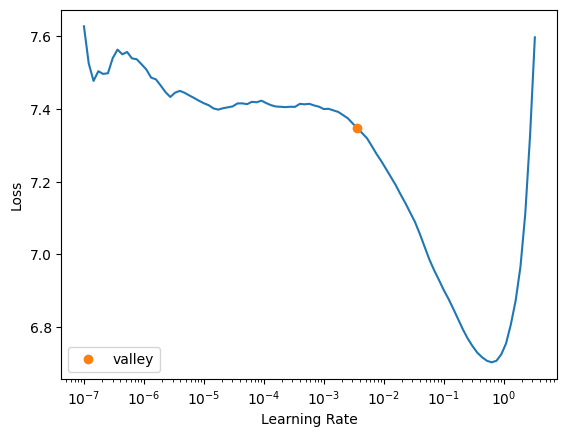

In [74]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

# Find optimal learning rate
lr_min = learn_lm.lr_find()

Now, lets fit and save this language model to use later.

In [75]:
learn_lm.fit_one_cycle(5, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.879542,6.237139,0.153429,511.393188,00:09
1,6.140581,5.626388,0.184225,277.657288,00:06
2,5.639164,5.489933,0.198509,242.240860,00:07
3,5.350013,5.446927,0.200264,232.043900,00:05
4,5.194978,5.441590,0.200560,230.808838,00:06


We can do a few more epochs after unfreezing all the layers. This process will train the whole neural network rather than just the last few layers.

Unfreezing all layers in a neural network model allows backpropagation to update all weights, essentially enabling learning for the entire network. This is a common approach in fine-tuning a pre-trained model, where you first train with frozen layers (to get the last layers to an appropriate state), then unfreeze and continue training.

In [76]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.017103,5.355978,0.204861,211.870987,00:09
1,4.906485,5.276431,0.208728,195.670197,00:05
2,4.764768,5.243561,0.210365,189.343109,00:08
3,4.601172,5.182724,0.221275,178.167389,00:05
4,4.411473,5.194472,0.218829,180.272995,00:08
5,4.229151,5.211241,0.218513,183.321457,00:09
6,4.059680,5.195732,0.223840,180.500153,00:07
7,3.902682,5.232059,0.223879,187.177902,00:06
8,3.734227,5.261512,0.222715,192.772797,00:06
9,3.618112,5.267314,0.221808,193.894547,00:08


We got a maximum accuracy of around 25%, this means that our model can correctly predict the next word one in every 4 times. Not so bad when you put it like that...

In [90]:
learn_lm.predict("I will love you", n_words=10)

"i will love you , love lust , love brutality 've done love many"

In [91]:
learn_lm.save('language_model')
learn_lm.save_encoder('encoder')

----------

Creating and training the the text classifier is very similar to training the language model.

We can start by creating the text_classifier_learner with the data_class DataLoaderand the AWD_LSTM architecture. Then, you can load the language model encoder.

In [103]:
dls_class = TextDataLoaders.from_df(df_with_lyrics, text_col='Lyrics', label_col='Genre', valid_pct=0.2, splitter = RandomSplitter(0.2))

In [104]:
learn_class = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [105]:
learn_class = learn_class.load_encoder('encoder')

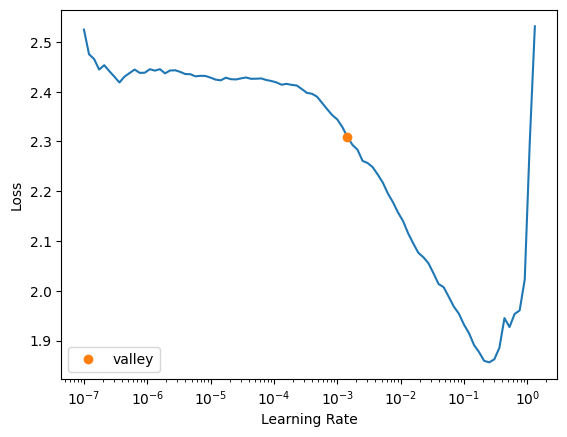

In [106]:
lr = learn_class.lr_find()

To train the classifier, we will use a technique called gradual unfreezing. We can start by training the last few layers, then go backwards and unfreeze and train layers before. We can use the learner function learn.freeze_to(-2) to unfreeze the last 2 layers.

In [107]:
learn_class.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.318399,2.174215,0.253886,00:02
1,2.031545,1.836846,0.404145,00:02
2,1.823150,1.670569,0.445596,00:02
3,1.680642,1.600414,0.471503,00:03
4,1.583205,1.583892,0.481865,00:04


If the loss keeps decreasing, this means that the model keeps improving.

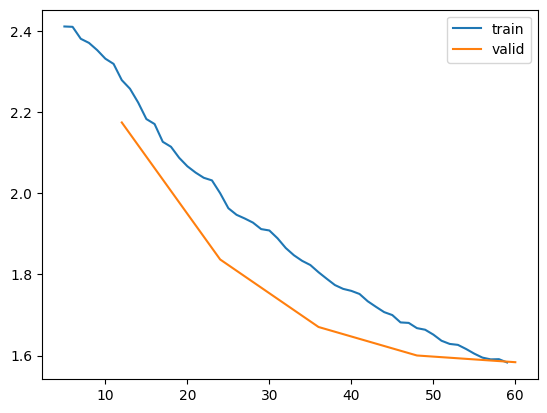

In [108]:
learn_class.recorder.plot_loss()

1. `freeze_to(-2)` freezes all layers except the last two groups. In practice, this means we are keeping the majority of the learned parameters the same (frozen), and only fine-tuning the last couple of layer groups.

2. `learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.95,0.85, 0.95))`: This function is training the model using the "1cycle" policy, an approach to training deep learning models. \
`slice(5e-3, 2e-3)` defines the learning rate(s) used during training. When a slice is passed, it is interpreted as (max_lr, start_lr). So in this case, the learning rate starts at 0.005 and decreases to 0.002 by the end of the cycle.\
`moms=(0.95,0.85, 0.95)` sets the momentums used in the optimizer. The tuple (0.95,0.85) means that the momentum will smoothly change from 0.95 to 0.85 as the learning rate increases, and will change back to 0.95 as the learning rate decreases again. Momentum is a technique used to help the optimizer navigate the parameter space.

In [109]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(5, slice(5e-3, 2e-3), moms=(0.95,0.85, 0.95))

epoch,train_loss,valid_loss,accuracy,time
0,1.359507,1.565969,0.476684,00:03
1,1.285647,1.506488,0.518135,00:04
2,1.161942,1.465970,0.523316,00:04
3,1.041647,1.471933,0.518135,00:03
4,0.951279,1.464089,0.518135,00:03


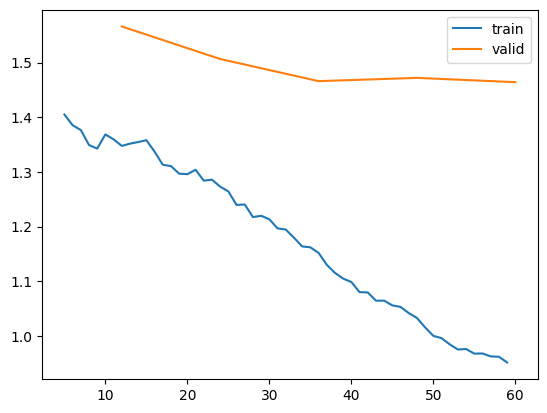

In [110]:
learn_class.recorder.plot_loss()

Finally, let us unfreeze all layers and train the model at a low learning rate.

Using a high learning rate may cause drastic changes to the weights, potentially leading to a model that performs worse because it forgets the valuable features it has already learned. By contrast, using a lower learning rate ensures that updates to the weights are more modest, preserving the previously learned features while gradually adapting the model to the new data.

In [111]:
learn_class.unfreeze()
learn_class.fit_one_cycle(15, slice(5e-3, 2e-3), moms=(0.95,0.85, 0.95))

epoch,train_loss,valid_loss,accuracy,time
0,0.732886,1.467246,0.533679,00:04
1,0.657938,1.467720,0.518135,00:06
2,0.580251,1.830099,0.445596,00:05
3,0.531700,1.819637,0.455959,00:04
4,0.481043,1.779340,0.518135,00:04
5,0.409743,1.681449,0.523316,00:05
6,0.340212,1.681585,0.523316,00:04
7,0.279163,1.713051,0.528497,00:04
8,0.224572,1.627542,0.528497,00:05
9,0.181402,1.611960,0.554404,00:05


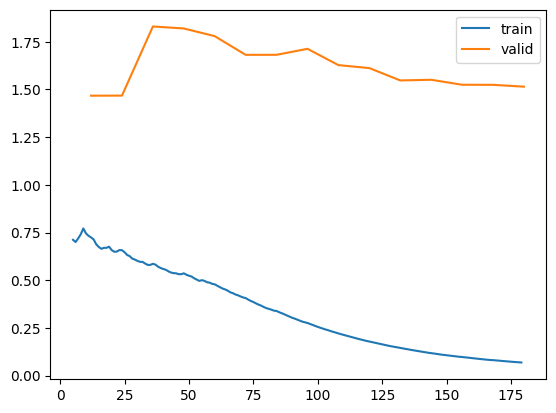

In [112]:
learn_class.recorder.plot_loss()

In [113]:
learn_class.show_results()

,text,category,category_
0,"xxbos buy it , use it , break it , fix trash it , change it , mail – upgrade charge it , point it , zoom it , press snap it , work it , quick – erase write it , cut it , paste it , save load it , check it , quick – rewrite plug it , play it , burn it , rip drag drop it , zip – unzip lock it , fill it , call it , find view it , code it , jam – unlock surf it , scroll it , pause it , click cross it , crack it , switch – update name it , read it , tune it , print scan it , send it , fax – rename touch it , bring it , pay it , watch turn it , leave it , start –",EDM,Reggae
1,"xxbos poverty 's paradise do n’t think could find way make earth ( i 've hungry life ) what 's up , family ? yeah , it ’s cousin xxunk , man , givin ' call , man know havin' lot yo ' mind lately know feel like , know people ai n't prayin ' understand this , man , cursed people xxunk xxunk says , "" the lord shall xxunk thee madness xxunk , xxunk heart "" see , family , that 's feel like feel like got chip shoulder follow commandments , gon na feel way … god , god got ta suffer ? pain heart carry xxunk full struggle god , god got ta bleed ? every stone thrown xxunk ' feet god , god got ta suffer ? earth more , wo n’t burn xxunk ? think could find way make earth xxunk xxunk xxunk uoy",Hip-Hop/Rap,Hip-Hop/Rap
2,"xxbos good god almighty — like back old days know , years ago xxunk men tell play , play know , whether xxunk rock but , uh , went studio champagne studio , course know , xxunk company laid back hope enjoy listening album half much xxunk playing ball real music gon na last bullshit today gone tomorrow cash rules everything around me , frikki - frikki - frik c.r.e.a.m . ; get the - get the - get the - get get the - get the - get the - get money , dollar - dollar d - d - d - d - dollar - dollar , dollar - dollar bill , y' all ( y' all , y' all ) cash rules everything around me , c.r.e.a.m get the - get the - get the - get the - get get the - get the - get",Hip-Hop/Rap,Hip-Hop/Rap
3,"xxbos mic on ? ( hey , move way , way ) hey , hey ! hey ! turn mic up , c'm on , c'm on mic not ? want mic we 're bringing nobody , nobody nobody number one rapper world done traveled world came back give game little boys girls , come ( ah , one two , one two , what 's happening , fool ? ) come right here , you , come done whole lot ( kendrick lamar ! ) trial , xxunk , know god devil wanna put bow tie ( make noise , brother ! ) pray holy water go dry look around many motherfuckers wanna xxunk never drown front dirty double - mirror found ( i love myself ) huh , lookin ' me , tell see ? ( i love myself ) ahh , put bullet back back head police",Hip-Hop/Rap,Hip-Hop/Rap
4,"xxbos 'cause sometimes feel tired yo , left , yo , left feel weak feel weak yo , left , right , left feel like wanna give yo , left , yo left got ta search within yo , left , right , left try find inner strength pull shit yo , left , yo left get motivation give yo , left , right , left xxunk , matter bad yo , left , yo left wanna fall flat face collapse yo , left , right , left ' til collapse i 'm spillin ' raps long feel 'em ' til day drop never say i 'm killin ' 'em ‘ cause not , i 'm a stop xxunk ' 'em hip - hop i 'm eminem xxunk thoughts , i 'm a stop sendin ' 'em ? women caught xxunk , spin 'em xxunk venom adrenaline shots xxunk could",Hip-Hop/Rap,Hip-Hop/Rap
5,"xxbos ugh , monster swallow bottle alcohol i 'll feel like godzilla better hit deck like card dealer whole squad 's here , walking around party cross zombie apocalypse b - bobby "" the brain "" xxunk probably reason wrestle xxunk shady 's bitch , i 'm xxunk consider cross xxunk mistake sleepin ' me , hoes better get xxunk adhd , xxunk pass xxunk ( hey , hey ) xxunk ak , xxunk , finna set like xxunk better xxunk , xxunk like vacay , mayday ( ayy ) beat cray - cray , ray j , h - a - h - a - h - a laughing way bank , spray flames can not tame xxunk monster get way , i 'm a feed monster ( yeah ) i 'm normal day , night , turn 

And this is it! We have trained our model and we can now use it to predict the genre of a song based on its lyrics.

We managed to improve the accuracy of it to around **57%**, which, considering that we have 10 different classes, and the size of our dataset, is not bad at all.

Let's export the model so we can use it later with our web app.

In [114]:
learn_class.save('NLP_GroupAssig_Model')

Path('models/NLP_GroupAssig_Model.pth')

---------------

### **Using Transformers**

In [45]:
import locale
locale.getpreferredencoding = lambda *args, **kwargs: "UTF-8"

The library `simpletransformers` provides us with a very easy way to use the HuggingFace Transformers library, which is a very powerful library for NLP we have already talked about.

In [41]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

Train test split, just like in normal Machine Learning

In [46]:
train, test = train_test_split(df_with_lyrics, test_size = 0.2)

Instantiating a RoBERTa model

In [47]:
from simpletransformers.classification import ClassificationModel

# Create a ClassificationModel
num_labels = test["Genre"].nunique()
model = ClassificationModel('roberta', 'roberta-base', num_labels=num_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should pr

We forgot to mention that encoding the target variables is usually needed, because models usually don't work with strings. We will use the `LabelEncoder` from sklearn to do this.

In [48]:
le = LabelEncoder()
train["Genre"] = le.fit_transform(train["Genre"])
test["Genre"] = le.fit_transform(test["Genre"])


train = train.iloc[:, ::-1]
test = test.iloc[:, ::-1]

test

,Lyrics,Genre
902,"babe, baby, baby, i'm gonna leave said baby, know i'm gonna leave i'll leave summertime leave summer comes a-rollin' leave summer comes along babe, babe, babe, babe, babe, babe, baby baby, wanna leave ain't joking' woman, i've got ramble oh, yeah, baby, baby, believin' really got ramble (i hear callin' me) hear callin' way used hear callin' back home oh, babe, i'm gonna leave oh, baby, know i've really got leave oh, hear callin' said hear callin' way used do? ooohh know, know, know never, never, never, never, never gonna leave you, babe got go away place i've got quit you, yeah oh, baby, b...",9
555,"let tell story chill bones thing saw one night wandering everglades i'd one drink rambling, enjoying bright moonlight gazing stars aware presence near watching every move feeling scared fell knees something rushed trees took unholy place fell grace summoned join dance dead circle fire followed middle led time stopped still numb fear still wanted go blaze fire hurt upon walked onto coals felt trance spirit lifted someone chance witness happened might also like danced, pranced, sang death eyes lifeless figures - undead - ascended hell danced dead free spirit laughing howling undead body danc...",5
606,"i'm like water ship rolled night rough surface, cut like knife open-shut case never would've known look face lost current like priceless wine say, less know wherever stray, follow i'm begging take hand wreck plans, that's man life willow bent right wind head pillow, could feel sneakin' mythical thing like trophy champion ring one prize i'd cheat win say, less know wherever stray, follow i'm begging take hand wreck plans, that's man know train could take home anywhere else hollow i'm begging take hand wreck plans, that's man might also like life willow bent right wind count time time life w...",6
355,"lickwood means ""rewind"" gunshot means ""forward"" requested it, rewind yeah, way, way, way turn up, yeah, look got enemies, got lot enemies got lot people tryna drain energy tryna take wave nigga fuckin' kid pray nigga got girls real life tryna fuck day fuck goin' online, ain't part day got real shit poppin' family got niggas never leave canada (six) got two mortgages, thirty million total got niggas still try fuckin' got rap niggas gotta act like like actin' days over, fuck niggas life, yeah got enemies, got lot enemies got lot people tryna drain energy tryna take wave nigga fuckin' kid pra...",3
877,"born river little tent oh, like river, i've runnin' ever since long long time comin', know change gon' come oh, yes hard livin' i'm afraid die 'cause know what's beyond sky long long time comin', know change gon' come oh, yes go movie go downtown somebody keep tellin' ""don't hang around"" might also like long long time comin', know change gon' come oh, yes go brother say, ""brother, help please"" winds knockin' back knees lor', times thought last long think i'm able carry long long time comin', know change gon' come oh, yes",7
...,...,...
760,"yes y'all, rockin best black thought legendary roots crew flesh slid brothers marley family, crestin, 'gon set y'all hey! loves party, good time looks hearty, feeling fine loves smoke, sometimes shifting coke laughing ain't joke, hey!!! (background singers) (pimpa's paradise) that's (pimpa's paradise) that's (pimpa's paradise) that's was, (pimpa's paradise) that's cause coke thing first tried blue moon blue sky wonderin else wants go buy got money wants get high story sounds familiar like born wild sillier, quite similiar waste sarsaparilla used look good videos look hideous broken crack p...",8
275,"know, i'm sorry make party got caught selfishness let part know i've started drifting every second can't wait leave soon arrive, count seconds go we'll torch place know one us takes chance breaks this, one no, one know pathetic fuck it, yeah, said tried tell like there's chance i'll regret it, let's go, let's end delete send play pretend like reached end yet might also like go we'll 

Training the roBERTa model on our data

In [49]:
model.train_model(train)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/772 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/97 [00:00<?, ?it/s]

(97, 2.224279659310567)

Evaulating its performance

In [50]:
result, model_outputs, wrong_predictions = model.eval_model(test)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/193 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Results and scores

In [51]:
result

{'mcc': 0.20300543249949107, 'eval_loss': 2.1088916015625}

**mcc**: Stands for Matthews correlation coefficient. The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.


**eval_loss**: It measures the dissimilarity between the predicted probability distribution and the true distribution of the target variable.
A lower cross entropy loss indicates better model performance, as it signifies a closer match between the predicted probabilities and the true labels.

In [52]:
model_outputs

array([[ 0.24987793,  0.05447388, -0.22241211, ...,  0.31713867,
        -0.28759766,  0.09588623],
       [ 0.00381088,  0.26220703, -0.11138916, ..., -0.15673828,
         0.21044922, -0.03372192],
       [ 0.17260742, -0.00068712, -0.2322998 , ...,  0.24938965,
        -0.23168945,  0.32397461],
       ...,
       [ 0.20483398, -0.11688232, -0.07666016, ...,  0.31762695,
        -0.13000488,  0.37426758],
       [ 0.25756836,  0.09381104, -0.29638672, ...,  0.30761719,
        -0.21960449,  0.08990479],
       [ 0.28198242,  0.1340332 , -0.0892334 , ...,  0.10742188,
        -0.13952637,  0.26757812]])

Just like with the Sentiment Analysis notebook, we used the Transformers library more for experimenting than actual usage, since a task like this would be complete overkill for a dataset like this one.